# Восстановление золота из руды

Для компании-разработчика решений для эффективной работы промышленных предприятий необходимо подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Предоставленные данные включают в себя параметры добычи и очистки. Модель должна оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель исследования** - обучить модель, которая предскажет коэффициент восстановления золота из золотосодержащей руды со значением метрики sMAPE (Symmetric Mean Absolute Percentage Error) не более 9.

**Ход исследования:**
1. Загрузка и подготовка данных.
2. Исследовательский анализ данных.
3. Построение и обучение модели.
4. Общий вывод.

Предоставленные данные находятся в трёх файлах: обучающая, тестовая выборки и исходные данные. Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

**Описание данных:**

Названия столбцов в датасетах имеют следующую структуру: этап.тип_параметра.название_параметра

**Технологический процесс:**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Значения для блока "этап":**
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

**Значения для блока "Тип_параметра"**:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

In [2]:
try:
    gold_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    gold_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    gold_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    
except:
    gold_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
    gold_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
    gold_full = pd.read_csv('datasets/gold_recovery_full_new.csv')
    
gold_train.name='gold_train'
gold_test.name='gold_test'
gold_full.name='gold_full'

### Обзор данных

In [3]:
for data in [gold_train, gold_test, gold_full]:
    print ('\033[1m' + f'Датасет {data.name}' + '\033[0m')
    display(data.head())
    display(data.describe())
    data.info()
    print('Дубликатов: ', data.duplicated().sum())
    print()   

Датасет gold_train


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000,14148.000,13938.000,14149.000,14149.000,14149.000,14049.000,14144.000,14149.000,14129.000,14117.000,14149.000,14049.000,14149.000,14063.000,13863.000,14149.000,14148.000,14134.000,14103.000,14149.000,14145.000,14148.000,14145.000,14148.000,14147.000,14148.000,14146.000,14148.000,14148.000,14148.000,14148.000,14149.000,14149.000,14049.000,14141.000,14005.000,14071.000,14149.000,14120.000,14141.000,14113.000,13721.000,14149.000,14149.000,14127.000,14149.000,14149.000,14148.000,14149.000,14149.000,14149.000,14148.000,14148.000,14148.000,14148.000,14148.000,14148.000,14149.000,14149.000,13713.000,14149.000,14149.000,14149.000,14147.000,14139.000,12544.000,14149.000,13932.000,14148.000,14128.000,14148.000,14145.000,14148.000,14148.000,14148.000,14143.000,14148.000,14148.000,14148.000,14148.000,14148.000,14148.000,14148.000,14147.000,14148.000
mean,5.142,10.133,9.203,44.004,66.519,9.607,2.597,10.512,2.918,133.321,8.867,7.322,0.886,8.201,9.589,10.115,32.387,16.304,3.443,7.534,3.840,1608.000,-488.776,1608.611,-489.172,1608.879,-489.606,1542.190,-483.462

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.801,14.993,8.080,1.005,1398.981,-500.226,1399.145,-499.920,1400.103,-500.704,1399.002,-499.485,13.129,5.637,489.794,62.710,42.022,12.084,16.923,6.153,16.868,6.151,1001.849,-350.301,1249.739,-399.108,1249.751,-399.397,1198.288,-399.489,999.472,-399.531,949.566,-398.181,24.938,-500.491,14.948,-500.014,20.018,-450.396,13.987,-449.832,12.024,-497.796,8.017,-501.289,7.947,-432.318,4.873,-500.037,26.706,-499.709
1,2016-09-01 01:59:59,215.392,14.987,8.080,0.990,1398.778,-500.057,1398.055,-499.778,1396.151,-499.240,1399.508,-500.416,13.036,5.526,490.105,61.961,41.188,11.919,17.003,5.999,16.996,6.002,998.691,-350.426,1248.395,-399.946,1249.514,-399.631,1200.506,-399.942,1000.002,-399.492,950.200,-405.788,24.923,-499.814,14.931,-500.764,19.989,-450.114,14.093,-450.059,12.058,-498.696,8.131,-499.634,7.958,-525.840,4.879,-500.162,25.020,-499.819
2,2016-09-01 02:59:59,215.260,12.885,7.787,0.996,1398.494,-500.868,1398.860,-499.765,1398.076,-502.152,1399.497,-499.715,13.138,5.427,489.618,66.904,42.546,12.091,16.993,5.851,16.982,5.854,998.517,-349.784,1247.441,-400.264,1248.207,-401.074,1199.770,-400.791,999.926,-399.237,950.320,-400.864,24.909,-500.304,14.997,-500.994,20.040,-450.263,14.078,-449.661,11.962,-498.767,8.097,-500.827,8.071,-500.802,4.905,-499.829,24.995,-500.623
3,2016-09-01 03:59:59,215.336,12.007,7.640,0.864,1399.618,-498.864,1397.440,-499.211,1400.129,-498.356,1401.065,-501.039,12.401,5.115,476.618,59.866,41.060,12.182,16.532,5.802,16.515,5.804,1000.277,-350.173,1251.323,-398.655,1250.494,-399.747,1199.399,-397.503,1001.931,-400.438,950.735,-399.803,24.894,-499.382,14.917,-499.862,20.031,-449.373,14.014,-449.527,12.033,-498.351,8.075,-499.474,7.897,-500.869,4.931,-499.964,24.949,-498.710
4,2016-09-01 04:59:59,199.099,10.683,7.530,0.806,1401.268,-500.808,1398.129,-499.505,1402.172,-500.811,1399.481,-499.374,11.327,4.767,488.248,63.315,41.269,11.290,13.607,5.738,13.650,5.740,996.541,-350.563,1304.659,-399.512,1306.456,-399.051,1248.699,-400.877,1058.839,-398.988,949.645,-399.278,24.887,-499.357,14.979,-500.187,19.962,-450.639,14.009,-450.022,12.025,-500.786,8.

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000,5285.000,5290.000,5286.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5287.000,5289.000,5269.000,5290.000,5285.000,5290.000,5282.000,5265.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5287.000,5290.000,5288.000,5290.000,5281.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000,5290.000
mean,174.840,8.684,7.266,1.384,1539.494,-497.666,1545.174,-500.273,1527.272,-498.331,1544.844,-500.200,9.372,3.798,489.801,55.951,37.717,9.335,13.856,6.468,13.922,6.512,1053.400,-395.733,1318.927,-475.241,1301.595,-474.837,1214.848,-475.682,1056.649,-469.030,997.950,-470.482,26.313,-502.751,21.949,-501.987,25.403,-507.490,20.982,-506.628,16.320,-505.145,13.735,-463.350,12.804,-501.329,9.881,-495.663,17.305,-501.793
std,43.027,3.072,0.610,0.643,116.798,19.952,122.225,32.968,122.538,21.965,124.773,31.045,1.926,0.955,108.036,19.082,5.491,1.620,3.351,1.065,3.224,0.887,121.139,91.086,156.450,45.649,171.270,45.860,185.763,47.845,131.543,59.326,128.219,60.759,3.430,28.757,4.355,34.583,6.526,47.621,6.736,44.529,3.494,31.427,3.430,86.189,3.027,17.951,2.868,34.535,4.537,39.044
min,2.566,0.004,5.650,0.005,0.000,-795.316,0.000,-799.997,0.000,-799.961,0.000,-799.794,0.568,0.274,0.003,0.046,1.393,0.569,0.001,0.001,0.000,0.007,-0.042,-657.950,-0.722,-650.245,-0.057,-647.544,-0.992,-648.391,-1.982,-649.268,-2.593,-649.949,0.205,-784.091,0.006,-797.784,0.000,-799.756,0.000,-809.333,0.000,-799.799,0.000,-800.837,0.069,-797.324,0.528,-800.220,-0.079,-809.741
25%,147.121,6.490,6.890,0.908,1498.936,-500.357,1498.971,-500.703,1473.230,-501.018,1499.481,-500.452,8.112,3.240,407.021,43.906,34.506,8.208,11.995,5.999,11.997,5.999,999.205,-499.921,1200.872,-500.256,1199.651,-500.234,1093.368,-500.441,999.361,-500.191,901.025,-500.625,24.942,-500.207,20.002,-500.218,22.982,-500.298,17.968,-500.145,14.036,-500.868,12.029,-500.323,10.915,-500.727,8.037,-500.195,13.997,-500.691
50%,177.828,8.052,7.250,1.198,1585.129,-499.969,1595.622,-500.029,1549.595,-50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055,9.890,5.507,42.192,70.541,10.412,0.895,16.904,2.143,127.092,10.128,7.250,0.989,8.548,10.390,19.529,34.174,14.937,2.535,7.476,2.107,1549.776,-498.912,1551.434,-516.403,1549.874,-498.667,1554.367,-493.428,41885.707,3481.779,3520.337,2.839,6.100,2.285,523.546,55.487,36.809,6.486,11.987,6.008,11.837,6.006,11.501,7.101,28.029,19.794,87.108,5.008,0.509,19.154,1.170,999.707,-404.067,1603.011,-434.715,1602.375,-442.204,1598.937,-451.294,1404.472,-455.463,1416.355,-451.940,14.500,4.695,8.765,2.606,25.853,-498.526,23.894,-501.406,23.962,-495.263,21.940,-499.341,14.017,-502.488,12.100,-504.716,9.926,-498.310,8.080,-500.471,14.151,-605.842
1,2016-01-15 01:00:00,6.029,9.969,5.258,42.702,69.266,10.463,0.927,16.635,2.225,125.629,10.296,7.250,1.003,8.559,10.497,19.369,34.119,16.251,3.050,6.734,2.353,1576.167,-500.905,1575.951,-499.866,1575.994,-499.315,1574.479,-498.932,42050.862,3498.371,3489.982,2.859,6.161,2.266,525.291,57.279,35.753,6.479,11.971,6.006,11.996,6.013,11.616,7.279,28.067,20.051,86.843,4.955,0.537,18.965,1.185,1000.286,-400.065,

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000,19438.000,19228.000,19439.000,19439.000,19438.000,19338.000,19433.000,19439.000,19415.000,19402.000,19439.000,19335.000,19439.000,19323.000,19069.000,19439.000,19435.000,19418.000,19377.000,19439.000,19435.000,19438.000,19435.000,19438.000,19437.000,19438.000,19436.000,19438.000,19437.000,19437.000,19437.000,19439.000,19439.000,19339.000,19428.000,19294.000,19340.000,19439.000,19405.000,19431.000,19395.000,18986.000,19439.000,19439.000,19416.000,19439.000,19439.000,19438.000,19439.000,19439.000,19439.000,19438.000,19438.000,19438.000,19438.000,19438.000,19438.000,19439.000,19439.000,19003.000,19439.000,19439.000,19439.000,19437.000,19427.000,17691.000,19439.000,19219.000,19438.000,19416.000,19438.000,19426.000,19438.000,19438.000,19438.000,19433.000,19438.000,19438.000,19438.000,19438.000,19438.000,19438.000,19438.000,19437.000,19438.000
mean,5.168,9.979,9.501,44.077,67.050,9.689,2.706,10.584,3.042,144.625,8.817,7.307,1.022,8.442,9.830,10.489,32.119,16.146,3.436,7.973,3.914,1589.354,-491.195,1591.344,-492.193,1586.669,-491.980,1542.912,-488.017,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [4]:
print('Колонки, присутствующие в gold_train, но отсутствующие в gold_test:')
set(gold_train.columns)-set(gold_test.columns)

Колонки, присутствующие в gold_train, но отсутствующие в gold_test:


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Выводы**
* Датасеты gold_train и gold_full содержат по 87 столбца, в их числе столбец date, столбцы с данными по флотации (35), первичной очистке (20), вторичной очистке (22) и финальные характеристики (9). В том числе есть два столбца с целевыми признаками: rougher.output.recovery и final.output.recovery.
* В датасете gold_test всего 53 столбца, не хватает 35 столбцов: 13 - по флотации, 8 по первичной очистке, 4 - по вторичной очистке, совсем нет столбцов с финальными характеристиками. Нет столбцов  с целевыми признаками: rougher.output.recovery и final.output.recovery. Очевидно, что отсутсвующие признаки - это те, которые замерялись/рассчитывались позже. Это показатели концентраций металлов, хвосты и некоторые калькуляции.
* Тип данных во всех датасетах (помимо столбца date) - float. Во всех датасетах есть пропуски, полных дублей нет. Пропуски будет необходимо исследовать на этапе предобработки данных. Тип столбца date нужно будет изменить на datetime.
* Судя по медианным и средним значениям, распределение некоторых признаков стремится к нормальному, а некоторых других - нет. Это будет необходимо изучить на этапе исследовательского анализа данных.

### Предобработка данных

На этапе предобработки данных необходимо:
1. Тип данных столбцов date изменить на datetime;
2. Изучить пропуски в датасетах;
3. Добавить в gold_test столбцы с целевыми признаками (rougher.output.recovery и final.output.recovery).

Для начала проверим, есть ли дубли в столбцах date. Если нет, то есть если значения каждой строки уникальны, то на значения этого столбца можно опираться при перенесении признаков из одного датасета в другой.

In [5]:
for data in [gold_train, gold_test, gold_full]:
    print('Всего строк в датасете: ', len(data), '\n', 'уникальных значений date: ', len(pd.unique(data['date'])), end='\n\n')

Всего строк в датасете:  14149 
 уникальных значений date:  14149

Всего строк в датасете:  5290 
 уникальных значений date:  5290

Всего строк в датасете:  19439 
 уникальных значений date:  19439



In [6]:
# меняем тип данных столбца date
for data in [gold_train, gold_test, gold_full]:
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
    print('Новый формат date:', data['date'].dtypes)
print()
    
# добавляем целевые признаки в gold_test, на основании сходства значений столбца date
gold_test = gold_test.merge(gold_full[['date', 'final.output.recovery','rougher.output.recovery']], how='left', on='date')
gold_test.name='gold_test'
gold_test.info()

Новый формат date: datetime64[ns]
Новый формат date: datetime64[ns]
Новый формат date: datetime64[ns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float

Теперь изучим пропуски в датасетах

In [7]:
for data in [gold_train, gold_test, gold_full]:
    table=[]
    for col in data.columns:
        string=[]
        string.append(col)
        nans=data[col].isna().sum()
        if nans>0:
            string.append(nans)
            string.append(nans/len(data)*100)
            table.append(string)

    table = pd.DataFrame(table, columns=['column', 'nans', 'prc']).sort_values(by='prc', ascending=False).reset_index(drop=True)
    table = table.append({'column':'sum', 'nans':table['nans'].sum(), 'prc':table['prc'].sum()}, ignore_index=True)
    
    print('\033[1m' + f'Датасет {data.name}, пропуски' + '\033[0m')
    display(table)
    print()

Датасет gold_train, пропуски


,column,nans,prc
0,secondary_cleaner.output.tail_sol,1605,11.344
1,rougher.state.floatbank10_e_air,436,3.081
2,rougher.input.floatbank11_xanthate,428,3.025
3,primary_cleaner.output.concentrate_sol,286,2.021
4,secondary_cleaner.state.floatbank2_a_air,217,1.534
...,...,...,...
58,rougher.state.floatbank10_a_level,1,0.007
59,rougher.state.floatbank10_b_air,1,0.007
60,rougher.state.floatbank10_b_level,1,0.007
61,secondary_cleaner.state.floatbank6_a_level,1,0.007



Датасет gold_test, пропуски


,column,nans,prc
0,rougher.input.floatbank11_xanthate,25,0.473
1,rougher.input.feed_sol,21,0.397
2,secondary_cleaner.state.floatbank3_a_air,9,0.170
3,rougher.input.floatbank11_sulfate,8,0.151
4,primary_cleaner.input.depressant,5,0.095
5,rougher.input.floatbank10_sulfate,5,0.095
6,primary_cleaner.input.sulfate,4,0.076
7,primary_cleaner.input.xanthate,4,0.076
8,rougher.input.feed_rate,3,0.057
9,secondary_cleaner.state.floatbank2_a_air,3,0.057



Датасет gold_full, пропуски


,column,nans,prc
0,secondary_cleaner.output.tail_sol,1748,8.992
1,rougher.input.floatbank11_xanthate,453,2.330
2,rougher.state.floatbank10_e_air,436,2.243
3,primary_cleaner.output.concentrate_sol,370,1.903
4,secondary_cleaner.state.floatbank2_a_air,220,1.132
...,...,...,...
59,primary_cleaner.state.floatbank8_b_level,1,0.005
60,primary_cleaner.state.floatbank8_a_level,1,0.005
61,final.output.tail_ag,1,0.005
62,secondary_cleaner.state.floatbank6_a_level,1,0.005


В датасетах gold_train и gold_full пропусков довольно много, 29% и 23% соответственно. Поскольку данные в этих сетах индексируются датой и временем получения информации (признак date), а соседние по времени параметры часто похожи, заполним пропуски в этих сетах методом ffill, то есть последним имеющимся значением.

In [8]:
gold_train = gold_train.fillna(method='ffill')
gold_full = gold_full.fillna(method='ffill')
gold_test = gold_test.fillna(method='ffill')

gold_train.info()
print()
gold_full.info()
print()
gold_test.info()

gold_train.name = 'gold_train'
gold_full.name = 'gold_full'
gold_test.name = 'gold_test'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14149 non-null  float64       
 2   final.output.concentrate_pb                         14149 non-null  float64       
 3   final.output.concentrate_sol                        14149 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14149 non-null  float64       
 8   final.

### Проверка расчета эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке (gold_train) для признака rougher.output.recovery. Также найдем MAE между произведенными расчётами и истинными значениями признака.

Создадим функцию, которая будет рассчитывать эффективность обогащения по формуле

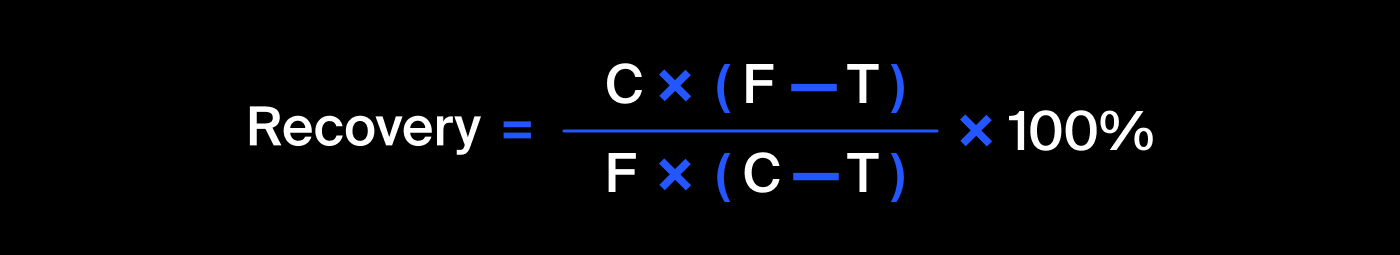

где:
* C — доля золота в концентрате после флотации/очистки, в данном случае признак rougher.output.concentrate_ag;
* F — доля золота в сырье/концентрате до флотации/очистки, в данном случае признак rougher.input.feed_au;
* T — доля золота в отвальных хвостах после флотации/очистки, в данном случае признак rougher.output.tail_au.

In [9]:
def recovery_check(data):
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    result = ((C*(F-T)) / (F*(C-T))) * 100  
    return result

In [10]:
gold_train['rougher.output.recovery.check'] = gold_train.apply(recovery_check, axis=1)
print(gold_train[['rougher.output.recovery', 'rougher.output.recovery.check']].info(10))
print()
print('MAE: ', mean_absolute_error(gold_train['rougher.output.recovery'], gold_train['rougher.output.recovery.check']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.output.recovery        14149 non-null  float64
 1   rougher.output.recovery.check  14149 non-null  float64
dtypes: float64(2)
memory usage: 221.2 KB
None

MAE:  9.73512347450521e-15


Метрика MAE близка к нулю, таким образом, можно считать, что рассчитанная эффективность обогащения практически не отличается от истинной, это значит, что данную формулу можно применять и в дальнейшем. Также удалим из обучающего датасета столбец с проверкой.

In [11]:
gold_train = gold_train.drop('rougher.output.recovery.check', axis=1)
gold_train.name='gold_train'

## Исследовательский анализ данных

### Концентрация металлов

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки относительно начального этапа. В связи с этим нас будут интересовать признаки с маркером "output.concentrate" в названии, а также "input.feed" (начальные концентрации), построим по ним графики распределения.

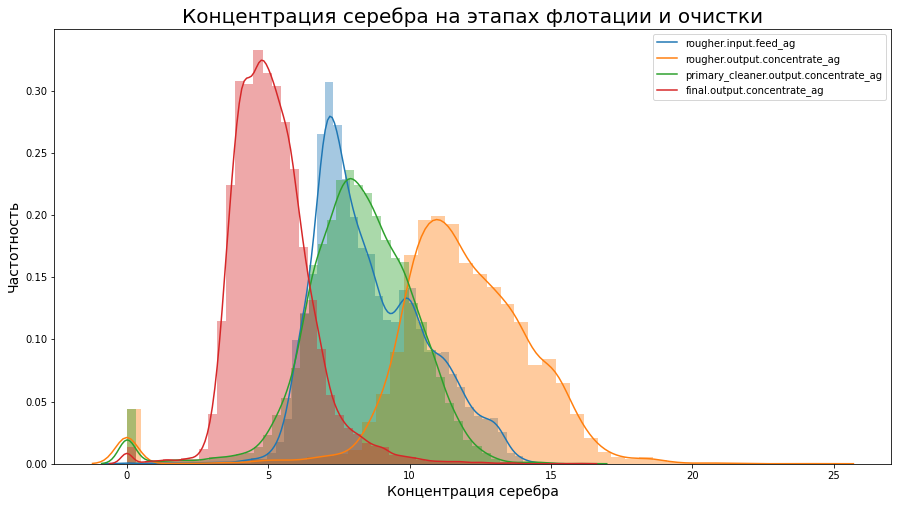

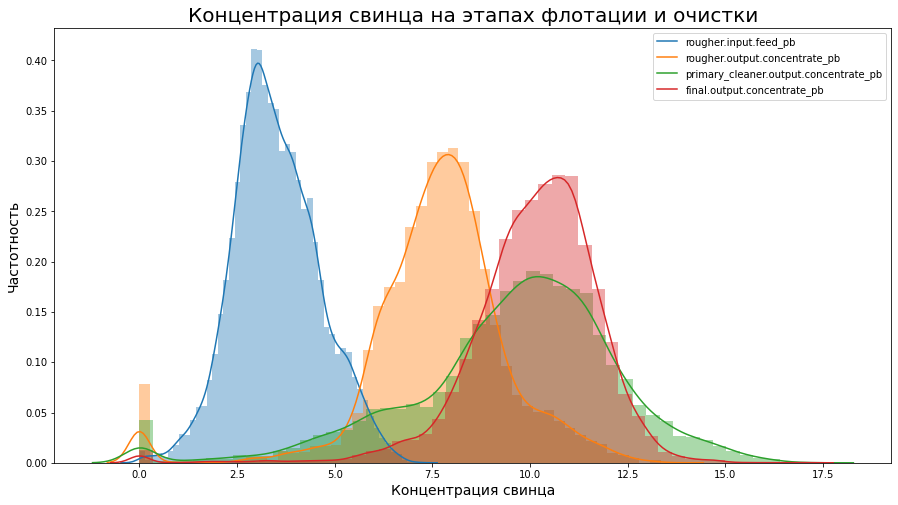

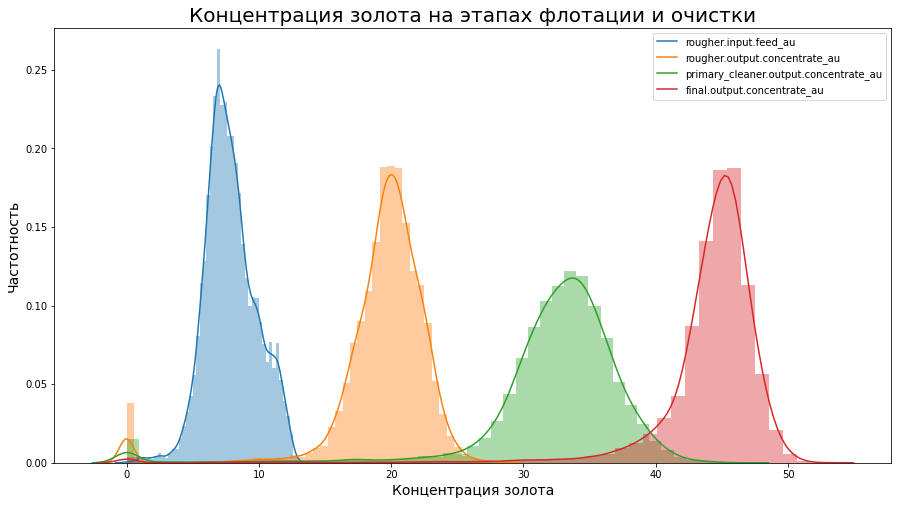

In [12]:
for col, name in zip([['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],
            ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'],
            ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']],
            ['серебра', 'свинца', 'золота']):
    plt.figure(figsize=(15, 8))
    sns.distplot(gold_train[col[0]])
    sns.distplot(gold_train[col[1]])
    sns.distplot(gold_train[col[2]])
    sns.distplot(gold_train[col[3]])
    plt.xlabel(f'Концентрация {name}', fontsize=14)
    plt.ylabel('Частотность', fontsize=14)
    plt.title(f'Концентрация {name} на этапах флотации и очистки', fontsize=20)
    plt.legend(col)
    plt.show()

**Выводы**
* По данным графикам видно, что концентрация всех металлов меняется на различных этапах очистки.
* Концентрация серебра относительно начальной сразу после флотации возрастает (примерно на треть), а потом постепенно снижается (в итоге, примерно в 2 раза).
* Концентрация золота поэтапно и последовательно возрастает (относительно начальных данных - более чем в 5 раз).
* концентрация свинца также возрастает (более, чем в 3 раза).

### Распределение размеров гранул сырья

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной. Очевидно, что размер гранул сырья отражает признак с маркером "input.feed_size" в названии. Сравним эти признаки на этапе флотации и первичной очистки, на тестовой и обучающей выборке.

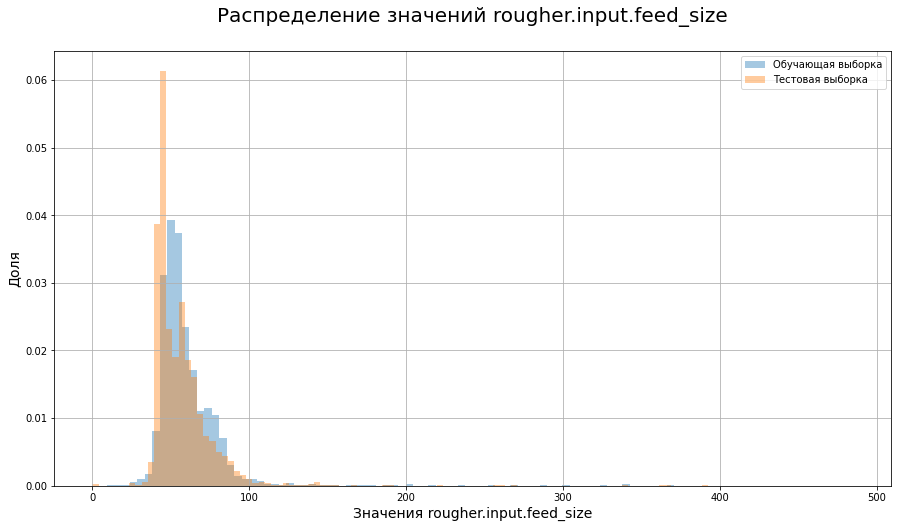

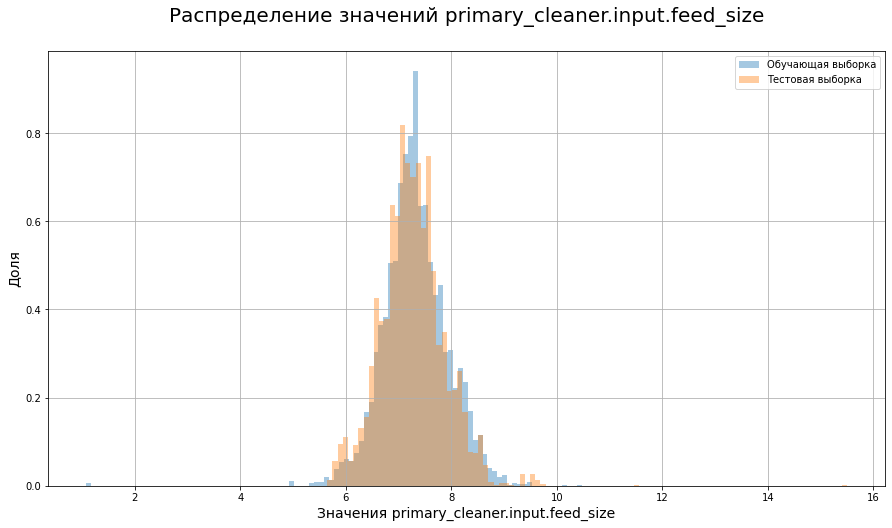

In [13]:
for i in ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']:
    gold_train[i].hist(bins=100, figsize=(15,8), density=True, alpha=0.4)
    gold_test[i].hist(bins=100, density=True, alpha=0.4)
    plt.title(f'Распределение значений {i}\n', fontsize=20)
    plt.legend(['Обучающая выборка','Тестовая выборка'])
    plt.xlabel(f'Значения {i}', fontsize=14)
    plt.ylabel('Доля', fontsize=14)
    plt.show()

Видно, что на этапе флотации график скошен вправо, есть выбросы после 150. Посмотрим на них более детально.

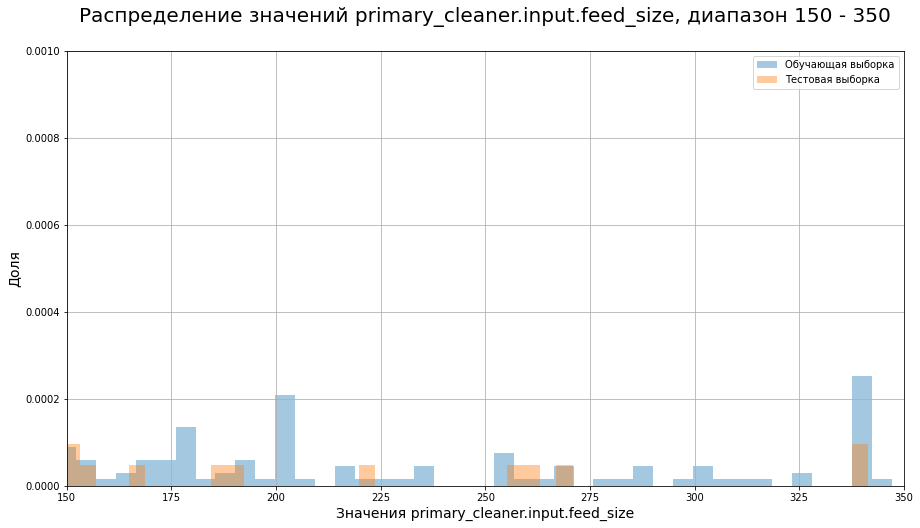

In [14]:
gold_train['rougher.input.feed_size'].hist(bins=100, figsize=(15,8), density=True, alpha=0.4)
gold_test['rougher.input.feed_size'].hist(bins=100, density=True, alpha=0.4)
plt.legend(['Обучающая выборка','Тестовая выборка'])
plt.xlim(150, 350)
plt.ylim(0, 0.001)
plt.title(f'Распределение значений {i}, диапазон 150 - 350\n', fontsize=20)
plt.ylabel('Доля', fontsize=14)
plt.xlabel(f'Значения {i}', fontsize=14)
plt.show()

**Выводы**
* Признаки input.feed_size в датасетах gold_train и gold_test распределены весьма схожим образом. 
* На этапе флотации есть выбросы в диапазоне 150-350, но они присутствуют в обоих датасетах, то есть можно считать, что в данном случае тестовая выборка репрезентативна.
* На этапе первичной обработки распределения крайне похожи.

### Суммарная концентрация всех веществ

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Для этого в обучающем и общем датасетах создадим столбцы с суммой значений признаков "input.feed" (сырье) и "output.concentrate" по всем металлам и по каждому этапу очистки. В дальнейшем изучим эти столбцы.

In [15]:
for data in [gold_train, gold_full]:
    data['rougher.input.feed_sum'] = data.loc[:, ['rougher.input.feed_ag',
                                       'rougher.input.feed_pb', 'rougher.input.feed_sol',
                                       'rougher.input.feed_au']].sum(axis=1)    
    data['rougher.output.concentrate_sum'] = data.loc[:, ['rougher.output.concentrate_ag',
                                       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
                                       'rougher.output.concentrate_au']].sum(axis=1)
    data['primary_cleaner.output.concentrate_sum'] = data.loc[:, ['primary_cleaner.output.concentrate_ag',
                                       'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
                                       'primary_cleaner.output.concentrate_au']].sum(axis=1)
    data['final.output.concentrate_sum'] = data.loc[:, ['final.output.concentrate_ag',
                                       'final.output.concentrate_pb', 'final.output.concentrate_sol',
                                       'final.output.concentrate_au']].sum(axis=1)
    display(data[['rougher.input.feed_sum', 'rougher.output.concentrate_sum',
        'primary_cleaner.output.concentrate_sum', 'final.output.concentrate_sum']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   rougher.input.feed_sum                  14149 non-null  float64
 1   rougher.output.concentrate_sum          14149 non-null  float64
 2   primary_cleaner.output.concentrate_sum  14149 non-null  float64
 3   final.output.concentrate_sum            14149 non-null  float64
dtypes: float64(4)
memory usage: 442.3 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   rougher.input.feed_sum                  19439 non-null  float64
 1   rougher.output.concentrate_sum          19439 non-null  float64
 2   primary_cleaner.output.concentrate_sum  19439 non-null  float64
 3   final.output.concentrate_sum            19439 non-null  float64
dtypes: float64(4)
memory usage: 607.6 KB


None

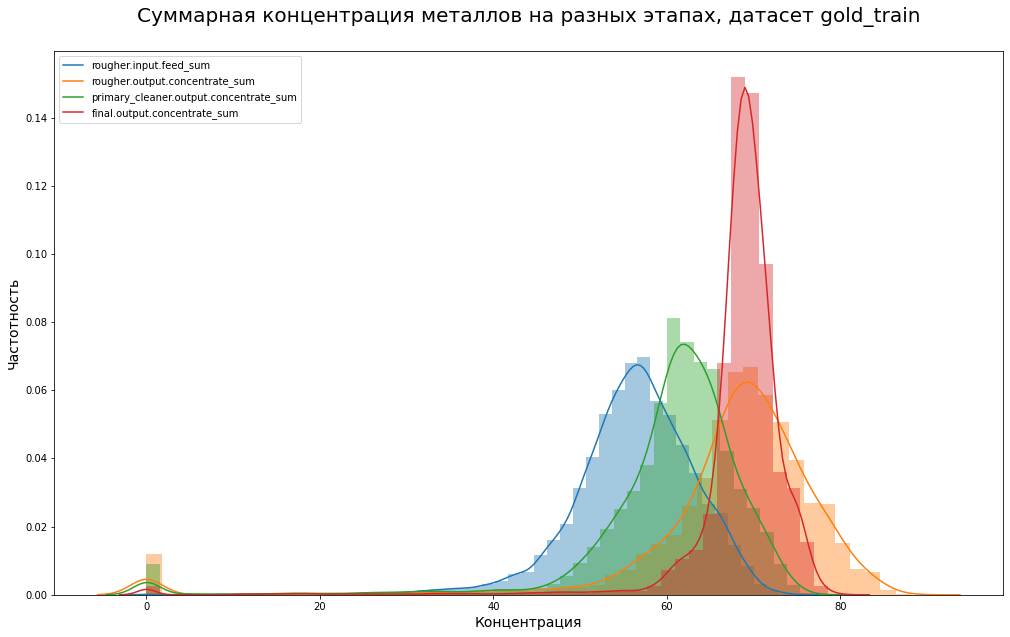

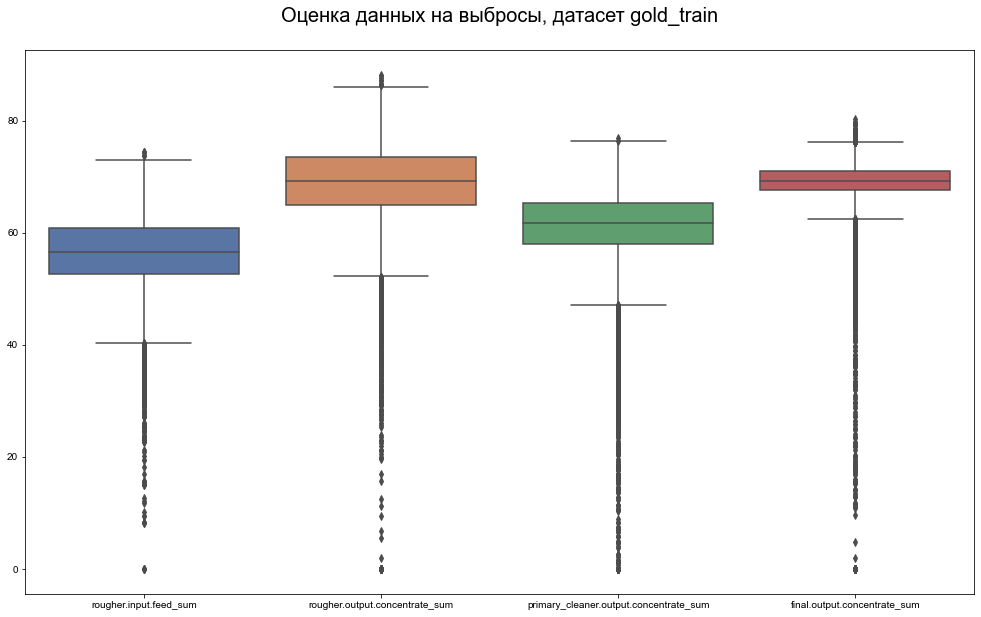

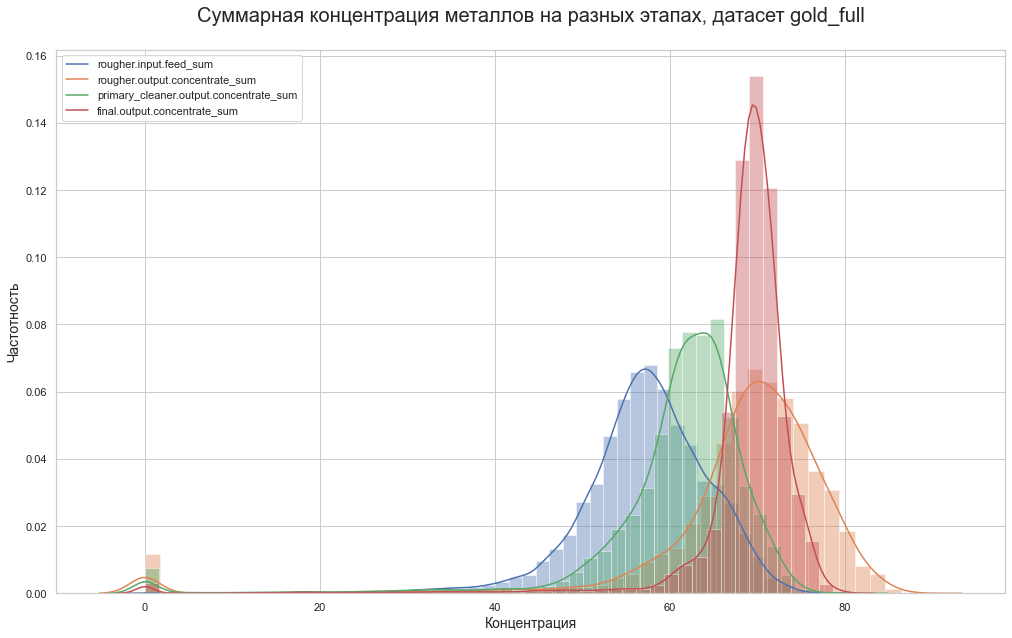

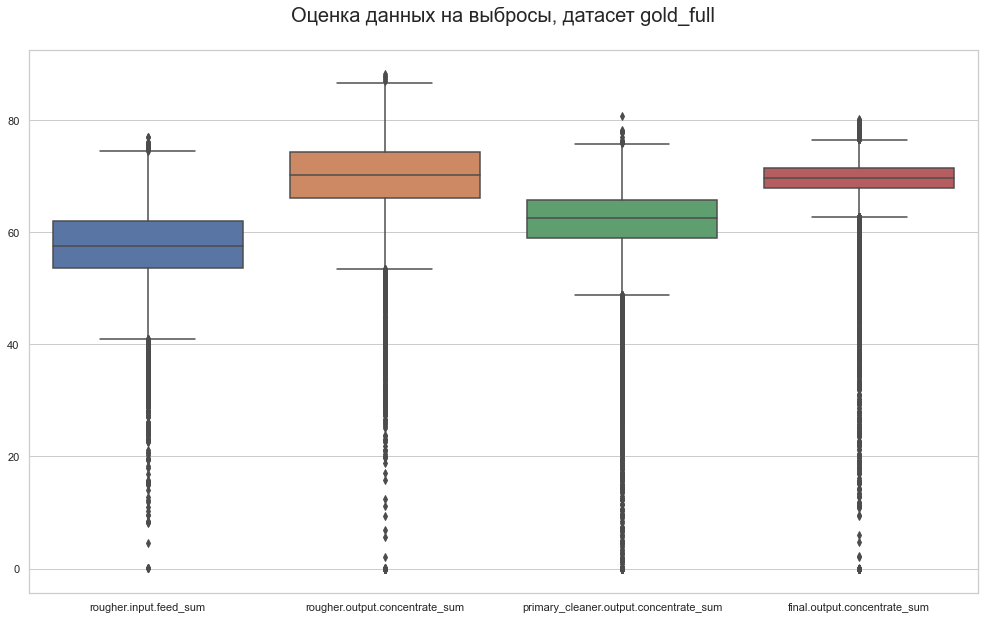

In [16]:
cols = ['rougher.input.feed_sum', 'rougher.output.concentrate_sum',
        'primary_cleaner.output.concentrate_sum', 'final.output.concentrate_sum']

for data in [gold_train, gold_full]:
    plt.figure(figsize=(17, 10))
    sns.distplot(data[cols[0]])
    sns.distplot(data[cols[1]])
    sns.distplot(data[cols[2]])
    sns.distplot(data[cols[3]])
    plt.xlabel(f'Концентрация', fontsize=14)
    plt.ylabel('Частотность', fontsize=14)
    plt.title(f'Суммарная концентрация металлов на разных этапах, датасет {data.name}\n', fontsize=20)
    plt.legend(cols)
    plt.show()
    
    plt.figure(figsize=(17, 10))
    plt.title(f'Оценка данных на выбросы, датасет {data.name}\n', fontsize=20)
    a=sns.set(style="whitegrid")
    a=sns.boxplot(data=data[cols])
    plt.show()
    print()

По графикам видно, что в данных по концентрации металлов много выбросов, как в обучающей выборке, так и в исходной (в тестовой выборке данных по концентрации металлов нет). Очевидно, будет правильным, если мы удалим из датасетов все строки, где суммарное значение концентрации металлов меньше 40.

Оценим долю таких строк в датасетах.

In [17]:
for data in [gold_train, gold_full]:
    print ('\033[1m' + f'Датасет {data.name}' + '\033[0m')
    print('Изначальное количество строк в датасете:', len(data))
    garb = len(data[(data['rougher.output.concentrate_sum']<40) |
                (data['primary_cleaner.output.concentrate_sum']<40) |
                (data['final.output.concentrate_sum']<40) | 
                 (data['rougher.input.feed_sum']<40)])
    print(f'Доля выбросов: {garb} строк, {round(garb/len(data)*100, 2)}%')

Датасет gold_train
Изначальное количество строк в датасете: 14149
Доля выбросов: 1245 строк, 8.8%
Датасет gold_full
Изначальное количество строк в датасете: 19439
Доля выбросов: 1592 строк, 8.19%


Доля выбросов в обоих случаях составляет менее 10%, а их наличие может помешать обучению. В связи с этим удалим выбросы из датасетов.

In [18]:
gold_train = gold_train.loc[gold_train['rougher.input.feed_sum']>=40]
gold_train = gold_train.loc[gold_train['rougher.output.concentrate_sum']>=40]
gold_train = gold_train.loc[gold_train['primary_cleaner.output.concentrate_sum']>=40]
gold_train = gold_train.loc[gold_train['final.output.concentrate_sum']>=40]
print ('\033[1m' + f'Датасет gold_train' + '\033[0m')
print(gold_train.shape, end='\n\n')

gold_full = gold_full.loc[gold_full['rougher.input.feed_sum']>=40]
gold_full = gold_full.loc[gold_full['rougher.output.concentrate_sum']>=40]
gold_full = gold_full.loc[gold_full['primary_cleaner.output.concentrate_sum']>=40]
gold_full = gold_full.loc[gold_full['final.output.concentrate_sum']>=40]
print ('\033[1m' + f'Датасет gold_full' + '\033[0m')
print(gold_full.shape)

gold_train.name = 'gold_train'
gold_full.name = 'gold_full'

Датасет gold_train
(12904, 91)

Датасет gold_full
(17847, 91)


## Обучение моделей

### Подготовка к обучению

Напишем функцию для вычисления метрики sMAPE, на основании данной формулы:

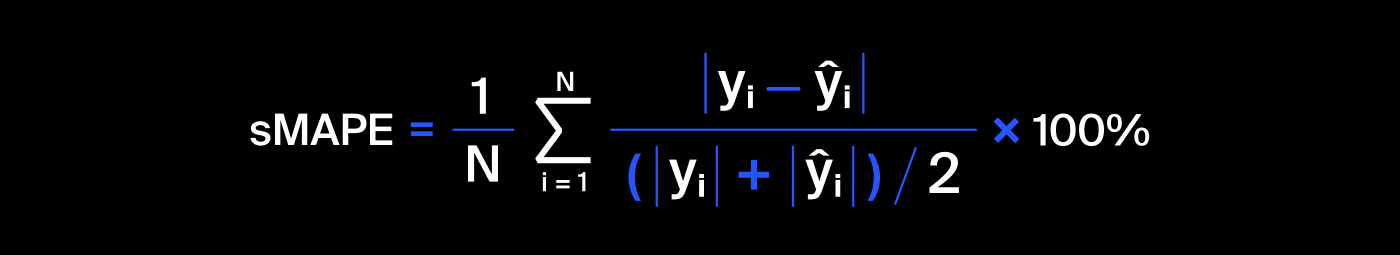

На вход функция будет принимать истинные значения целевого признака (из валидационной выборки) и предсказанные значения.

Также необходимо исходить из того, что как истинные значения, так предсказания будут содержать по два признака - recovery для флотации и для очистки. Функция должна вычислять итоговую метрику sMAPE по обоим признакам на основании формулы:

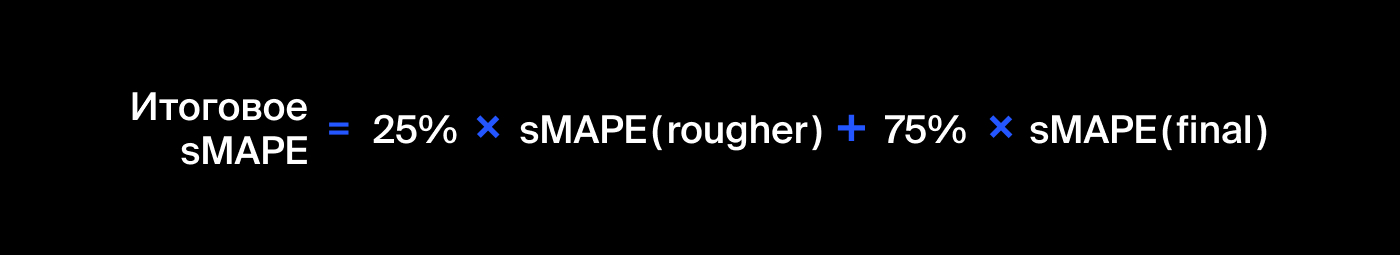

In [19]:
def smape_calc(target, preds):
    target_r = target['rougher.output.recovery']
    target_f = target['final.output.recovery']
    preds_r = preds[:, 0]
    preds_f = preds[:, 1]
    
    smape_r = abs((abs(target_r - preds_r) / ((abs(target_r) + abs(preds_r)) /2) * 100).mean())
    smape_f = abs((abs(target_f - preds_f) / ((abs(target_f) + abs(preds_f)) /2) * 100).mean())
    smape = 0.25 * smape_r + 0.75 * smape_f
    
    return smape

Теперь подготовим выбоки, обучим различные модели и оценим их качество кросс-валидацией.

In [20]:
# разделим выборки на обучающие и целевые признаки, из обучающих признаков уберем date
features = gold_train.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis=1)
target = gold_train[['rougher.output.recovery', 'final.output.recovery']]
features_test = gold_test.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = gold_test[['rougher.output.recovery', 'final.output.recovery']]

# оставим в обучающей выборке только те данные, которые есть в тестовой выборке, чтобы наборы совпадали
features = features[features_test.columns]

print('Обучающая выборка', features.shape, target.shape)
print('Тестовая выборка', features_test.shape, target_test.shape)

sample_size = int(len(target)/8) # возьмем число 8, так как количество строк в features кратно 8
scorer = make_scorer(smape_calc, greater_is_better=False)
rand_state = 3208

Обучающая выборка (12904, 52) (12904, 2)
Тестовая выборка (5290, 52) (5290, 2)


### Поиск лучших моделей

Построим модели 4х типов - RandomForestRegressor, XGBRegressor, Ridge и LinearRegression. Переберем гиперпараметры с помощью GridSearchCV.

In [21]:
%%time

forest_model = RandomForestRegressor(random_state=rand_state, verbose=0)

parameters = {'n_estimators': [70],             #range(30, 101, 10),
              'max_depth': [4]}                 #range(3, 15)}

gridsearch_forest_model = GridSearchCV(forest_model, parameters, cv=8, scoring=scorer, verbose=0)
gridsearch_forest_model.fit(features, target)

forest_model = gridsearch_forest_model.best_estimator_
forest_smape = abs(gridsearch_forest_model.best_score_)

mae_cross = cross_val_score(forest_model, features, target, scoring="neg_mean_absolute_error", cv=8)
forest_mae = np.array(mae_cross).mean()*-1

print('Модель RandomForestRegressor')
print('sMAPE: {:.3f} | MAE: {:.3f}'.format(forest_smape, forest_mae))
print(gridsearch_forest_model.best_params_)

Модель RandomForestRegressor
sMAPE: 8.125 | MAE: 5.420
{'max_depth': 4, 'n_estimators': 70}
CPU times: total: 2min 34s
Wall time: 2min 42s


In [22]:
%%time

xgb_model = XGBRegressor(random_state=rand_state)

parameters = {'learning_rate': [0.4],                      #[0.01, 0.02, 0.03, 0.04],
              'n_estimators':  [100],                      #[60, 80, 100],
              'max_depth': [3]}                            #range(3, 11)}

gridsearch_xgb_model = GridSearchCV(xgb_model, parameters, cv=8, scoring=scorer)
gridsearch_xgb_model.fit(features, target)

xgb_model = gridsearch_xgb_model.best_estimator_
xgb_smape = abs(gridsearch_xgb_model.best_score_)

mae_cross = cross_val_score(xgb_model, features, target, scoring="neg_mean_absolute_error", cv=8)
xgb_mae = np.array(mae_cross).mean()*-1

print('Модель XGBRegressor')
print('sMAPE: {:.3f} | MAE: {:.3f}'.format(xgb_smape, xgb_mae))
print(gridsearch_xgb_model.best_params_)

Модель XGBRegressor
sMAPE: 8.702 | MAE: 5.590
{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 100}
CPU times: total: 3min 42s
Wall time: 1min 1s


In [23]:
%%time

ridge_model = Ridge(random_state=rand_state)

parameters = {'tol': [t for t in np.linspace(0.0001, 2, 20)],
              'alpha': [a for a in np.linspace(0, 3, 20)]}

gridsearch_ridge_model = GridSearchCV(ridge_model, parameters, cv=8, scoring=scorer, verbose=0)
gridsearch_ridge_model.fit(features, target)

ridge_model = gridsearch_ridge_model.best_estimator_
ridge_smape = abs(gridsearch_ridge_model.best_score_)

mae_cross = cross_val_score(ridge_model, features, target, scoring="neg_mean_absolute_error", cv=8)
ridge_mae = np.array(mae_cross).mean()*-1

print('Модель Ridge')
print('sMAPE: {:.3f} | MAE: {:.3f}'.format(ridge_smape, ridge_mae))
print(gridsearch_ridge_model.best_params_)

Модель Ridge
sMAPE: 8.981 | MAE: 5.803
{'alpha': 3.0, 'tol': 0.0001}
CPU times: total: 58.3 s
Wall time: 52.4 s


In [24]:
%%time

# обучаем модель линейной регрессии
linear_model = LinearRegression()
linear_model.fit(features, target)
smape_cross = cross_val_score(linear_model, features, target, scoring=scorer, cv=8)
mae_cross = cross_val_score(linear_model, features, target, scoring="neg_mean_absolute_error", cv=8)
linear_smape = np.array(smape_cross).mean()*-1
linear_mae = np.array(mae_cross).mean()*-1
            
print(f'Модель LinearRegression')
print('SMAPE = {:.3f}, MAE = {:.3f}'.format(linear_smape, linear_mae))

Модель LinearRegression
SMAPE = 8.982, MAE = 5.804
CPU times: total: 750 ms
Wall time: 520 ms


In [25]:
models = pd.Series(['RandomForestRegressor', 'XGBRegressor', 'Ridge', 'LinearRegression'])
smapes = pd.Series([forest_smape, xgb_smape, ridge_smape, linear_smape])
maes = pd.Series([forest_mae, xgb_mae, ridge_mae, linear_mae])
times = pd.Series(['2 min 37 s', '56.6 s', '47.7 s', '511 ms'])
table = pd.concat([smapes, maes, times], axis=1)
table = table.set_index(models)
table.columns=['sMAPE', 'MAE', 'Время обучения']
table

,sMAPE,MAE,Время обучения
RandomForestRegressor,8.125,5.420,2 min 37 s
XGBRegressor,8.702,5.590,56.6 s
Ridge,8.981,5.803,47.7 s
LinearRegression,8.982,5.804,511 ms


**Выводы**

Лучший результат показала модель случайного леса с гиперпараметрами max_depth = 4, n_estimators = 70. SMAPE = 8.125, MAE = 5.420.

### Проверка на тестовой выборке


Проверим качество обученных моделей на тестовой выборке. 

In [26]:
dummy_model = DummyRegressor()
dummy_model.fit(features, target)

for model, name in zip([forest_model, xgb_model, ridge_model, linear_model, dummy_model],
                       ['RandomForestRegressor', 'XGBRegressor', 'Ridge', 'LinearRegression', 'Проверка на адекватность']):
    predictions = model.predict(features_test)
    smape = smape_calc(target_test, predictions)
    mae = mean_absolute_error(target_test, predictions)
    print(f'{name}, результаты на тестовой выборке')
    print('SMAPE = {:.3f}, MAE = {:.3f}'.format(smape, mae), end='\n\n')

RandomForestRegressor, результаты на тестовой выборке
SMAPE = 8.990, MAE = 5.461

XGBRegressor, результаты на тестовой выборке
SMAPE = 10.570, MAE = 6.060

Ridge, результаты на тестовой выборке
SMAPE = 9.266, MAE = 5.791

LinearRegression, результаты на тестовой выборке
SMAPE = 9.266, MAE = 5.791

Проверка на адекватность, результаты на тестовой выборке
SMAPE = 9.691, MAE = 6.055



**Выводы**
* Наилучшие результаты на тестовой выборке показывает модель случайного леса (SMAPE = 8.990, MAE = 5.461), с гиперпараметрами max_depth = 4, n_estimators = 70. Кроме того, эти показатели лучше, чем у Dummy модели.

## Общий вывод

Перед исследованием была поставлена цель - обучить модель, которая предскажет коэффициент восстановления золота из золотосодержащей руды. Предоставленные данные включают в себя параметры добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Было известно, что данные находятся в трёх файлах: обучающая, тестовая выборки и исходные данные. Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Данные были загружены и проанализированы. В датиасетах были обнаружены пропуски. В датасетах gold_train и gold_full пропусков было довольно много, 29% и 23% соответственно. Поскольку данные в этих сетах индексируются датой и временем получения информации, пропуски были заполнены методом ffill. Также в датасет с тестовыми данными были добавлены столбцы с целевыми признаками (rougher.output.recovery и final.output.recovery).

Далее была произведена проверка расчета эффективности обогащения (то есть целевых признаков). Была создана функция, которая рассчитывала эти параметры по формуле от заказчика. Признак rougher.output.recovery был с её помощью вычислен на обучающей выборке. Сравнение с истинными значениями показало, что рассчитанная эффективность обогащения практически не отличается от истинной, метрика MAE близка к нулю.

Далее было изучено, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Были построены графики, которые показали, что концентрация всех металлов меняется на различных этапах очистки. Концентрация серебра относительно начальной сразу после флотации возрастает (примерно на треть), а потом постепенно снижается (в итоге, примерно в 2 раза).  Концентрация золота поэтапно и последовательно возрастает (относительно начальных данных - более чем в 5 раз). Концентрация свинца также возрастает (более, чем в 3 раза).

Далее сравнили распределения размеров гранул сырья на обучающей и тестовой выборках и на различных этапах очистки (если бы распределения на выборках сильно отличались друг от друга, оценка модели могла бы быть неправильной неправильной). Сравнение показало, что эти признаки на тестовой и обучающей выборках распределены весьма схожим образом. На этапе флотации есть выбросы в диапазоне 150-350, но они присутствуют в обоих датасетах, то есть можно считать, что в данном случае тестовая выборка репрезентативна. На этапе первичной обработки распределения крайне похожи.

Также была исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Для этого в обучающем и общем датасетах были созданы и изучены соответствующие столбцы. Графики показали, что в данных по концентрации металлов много выбросов, как в обучающей выборке, так и в исходной (в тестовой выборке данных по концентрации металлов нет). Было прнято решение удалить из датасетов все строки, где суммарное значение концентрации металлов меньше 40 (менее 10%).

Далее была создана функция для вычисления метрики sMAPE. На вход функция принимает истинные значения целевого признака (из валидационной выборки) и предсказанные значения. Также было учтено, что как истинные значения, так предсказания содержат  по два признака - recovery для флотации и для очистки. Функция вычисляет итоговую метрику sMAPE по обоим признакам.

Далее выборки были подготовлены, разделены на обучающие и целевые признаки, из обучающих признаков убран столбец date. В обучающей выборке оставлены только те столбцы, которые есть в тестовой выборке, чтобы наборы совпадали. После этого были обучены модели 4х типов - RandomForestRegressor, XGBRegressor, Ridge и LinearRegression. Гиперпараметры подбирались с помощью GridSearchCV. Лучший результат показала модель случайного леса с гиперпараметрами max_depth = 4, n_estimators = 70. SMAPE = 8.125, MAE = 5.420.

На тестовой выборке наилучшие результаты также показала модель случайного леса (SMAPE = 8.990, MAE = 5.461). Кроме того, эти показатели оказались лучше, чем у Dummy модели.